# Model Training

## Imports

In [55]:
from typing import Any

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt

## Read Data

### Helper functions

Read analysis data from CSV

In [13]:
def read_analysis_data(path: str) -> pd.DataFrame:
    return pd.read_csv(FILE_PATH_ANALYSIS_DATA, index_col=["option_name", "index"])

Prepare X, y

In [17]:
def get_X_y(df: pd.DataFrame, parameter: str, metric: str) -> tuple[np.ndarray, np.ndarray]:
    X = df.loc[(parameter), metric].to_numpy().reshape(-1,1)
    y = df.loc[(parameter), "option_value"].to_numpy()
    return X,y

### Get data

In [11]:
FILE_PATH_ANALYSIS_DATA = '../data/processed/analysis_LOM_data.csv'

In [30]:
df = read_analysis_data(FILE_PATH_ANALYSIS_DATA)

## Train Model

### Helper functions

Save model

In [25]:
def save_model(model: Any, path: str):
    """Save model

    Args:
        model (Any): Scikit-learn model
        path (str): Path to model
    """
    import pickle
    with open(path, 'wb') as file:
        pickle.dump(model, file)

Load model

In [24]:
def load_model(path: str) -> Any:
    """Load model

    Args:
        path (str): Path to model

    Returns:
        Any: Scikit-learn model
    """
    import pickle
    with open(path, 'rb') as file:
        model = pickle.load(file)
    return model

Plotting result

In [56]:
def plot_result(data: dict[str, Any], X: np.ndarray, y: np.ndarray, test_size: float, parameter: str, metric: str):
    """Plot the result

    Args:
        data (dict[str, Any]): Data to plot
    """
    best_seed = data['best_seed']
    X_train, X_test, _, _ = train_test_split(X, y, test_size=test_size, random_state=best_seed)

    # get the indices that would sort array a
    indices_train = np.argsort(X_train, axis=0).flatten()
    indices_test = np.argsort(X_test, axis=0).flatten()

    # use the indices to sort both arrays
    X_train = X_train[indices_train]
    X_test = X_test[indices_test]

    y_train_prediction = data['best_estimator'].predict(X_train)
    y_test_prediction = data['best_estimator'].predict(X_test)

    # Plot the results
    fig, axes = plt.subplots()
    axes.plot(X_train,
            y_train_prediction,
            label="Best fit line (train)")
    axes.scatter(X,
                y,
                facecolor="none", 
                edgecolor="black", 
                label="y_true")
    axes.scatter(X_train,
                y_train_prediction,
                color="green",
                label="y_train_prediction")
    axes.scatter(X_test,
                y_test_prediction,
                color="red",
                label="y_test_prediction")
    axes.legend(
        loc="best"
    )

    fig.text(0.5, 0.04, metric, ha="center", va="center")
    fig.text(0.06, 0.5, parameter, ha="center", va="center", rotation="vertical")
    fig.suptitle("Polynomial Ridge Regression", fontsize=14)
    plt.show()

### Generate seeds for model training

In [33]:
SIZE = 100
RANDOM_SEED = 42

rng = np.random.default_rng(RANDOM_SEED)
seeds = rng.integers(low=0, high=1000, size=SIZE)

### Training

In [40]:
def train(seeds: np.ndarray=None, test_size: float=0.20, X: np.ndarray=None, y: np.ndarray=None) -> dict[str, Any]:
    data = {
        "trials": {},
        "best_seed": -1,
        "best_estimator": None,
    }

    max_train_score = 0

    for seed in seeds:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

        clf2 = Ridge()
        # Create a pipeline for polynomial regression
        pipe2 = Pipeline([('standardscaler', StandardScaler()),('polynomialfeatures', PolynomialFeatures()), ('classifier', clf2)])

        # Set up the parameter grid for the polynomial degree and regularization strength
        params2 = {}
        params2['polynomialfeatures__degree'] = np.arange(1,10)
        params2['classifier__alpha'] = [0.1, 1, 10, 100]
        params2['classifier'] = [clf2]

        # get the indices that would sort array 
        indices = np.argsort(X_train, axis=0).flatten()

        # use the indices to sort both arrays
        X_sorted = X_train[indices]
        y_sorted = y_train[indices].ravel()

        # create a list of parameter dictionaries
        params = [params2]

        grid1 = GridSearchCV(pipe2, params)
        grid1.fit(X_sorted, y_sorted)

        # Store trial dadta
        data["trials"][seed] = {}
        data["trials"][seed]["best_params"] = grid1.best_params_
        data["trials"][seed]["training_score"] = grid1.best_score_
        data["trials"][seed]["test_score"] = grid1.best_estimator_.score(X_test, y_test)
        
        # Store best estimator
        if grid1.best_score_ > max_train_score:
            max_train_score = grid1.best_score_
            data["best_seed"] = seed
            data["best_estimator"] = grid1.best_estimator_

    test_scores = [data["trials"][seed]["test_score"] for seed in seeds]
    print(f"Test set R2 scores: {test_scores}")
    print(f"Mean R2 test score: {np.mean(test_scores)}")
    return data

### Predict `pad_gap` from `qubit frequency (fQ)`

In [63]:
TEST_SIZE=0.20
PARAMETER = "pad_gap_in_um"
METRIC = "fQ"
MODEL_PATH= f"../models/polynomial_ridge_regression_{METRIC}_{PARAMETER}.pkl"

Train model

In [53]:
X, y = get_X_y(df, parameter=PARAMETER, metric=METRIC)
data = train(seeds=seeds, test_size=TEST_SIZE, X=X, y=y)

Test set R2 scores: [0.988201345811011, 0.9895452478292662, 0.9939378022942692, 0.9904382206901483, 0.9952910315398218, 0.8416812870477892, 0.9942691004436393, 0.9747087740388316, -1.1476255547633438, 0.9914734299427368, 0.9963791102693191, 0.9987139076725652, 0.9904686530391316, 0.9948215918745921, 0.9935189142817924, 0.9948654052291728, 0.9443175414871916, 0.8382122445602831, 0.9603377870178328, 0.9952678735630296, 0.9586754749673974, 0.9836864407223204, 0.9443019770186416, 0.9915408148430273, 0.9616731482188978, 0.9979735980260996, 0.9469810410193361, 0.9795246426464441, 0.9952938138071374, 0.9889072532903675, 0.9952678735630296, 0.9975897322326752, 0.9979572272135585, 0.9888792658100548, 0.9886250647106624, 0.9944446164791751, 0.8416812870477892, 0.9926599866098841, 0.9855776407222406, 0.9871768894466907, 0.9893026562990124, 0.9993785310478787, 0.9613330888425711, 0.9968291702812545, 0.9938750970340621, 0.9938998183631316, 0.9407664862231366, 0.9303681150432158, 0.9790181348641253,

Plot

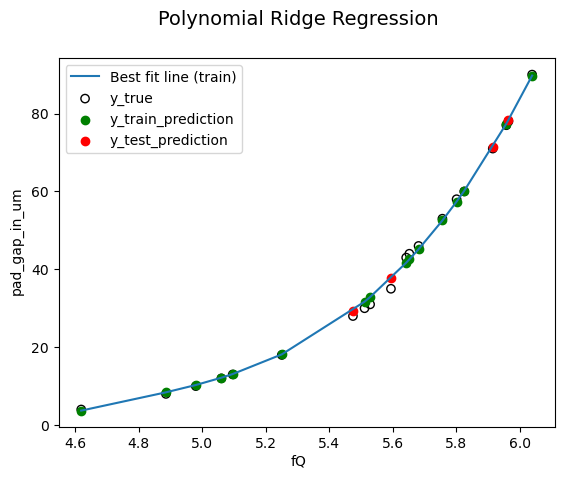

In [57]:
plot_result(data, X, y, test_size=TEST_SIZE, parameter=PARAMETER, metric=METRIC)

Save model

In [64]:
save_model(data["best_estimator"], MODEL_PATH)

### Predict `pad_height` from `qubit frequency (fQ)`

In [66]:
TEST_SIZE=0.20
PARAMETER = "pad_height_in_um"
METRIC = "fQ"
MODEL_PATH= f"../models/polynomial_ridge_regression_{METRIC}_{PARAMETER}.pkl"

Train model

In [67]:
X, y = get_X_y(df, parameter=PARAMETER, metric=METRIC)
data = train(seeds=seeds, test_size=TEST_SIZE, X=X, y=y)

Test set R2 scores: [0.9835034277549721, 0.9992496097323276, 0.998471770019882, 0.9866174415741773, 0.7577257051236514, 0.997139027472582, 0.9964023347980809, 0.9960416391567708, 0.9988484433763802, 0.9986100469952355, 0.9886828684027723, 0.9992337152617129, 0.9958671407523082, 0.9726692799671731, 0.9981980907559249, 0.9955405086662928, 0.9973003596013283, 0.9997353015942184, 0.9974015491861961, 0.9982050140921496, 0.991618863575147, 0.9988596690645444, 0.9967168978689739, 0.9877924701562683, 0.9908656566124617, 0.9029969403592275, 0.9969267976959648, 0.9970210838980084, 0.9951815027742555, 0.9922694205698284, 0.9982050140921496, 0.9939276322753444, 0.9893135282411135, 0.991180404389891, 0.9850709188185426, 0.9991562896984484, 0.997139027472582, 0.9945269521291968, 0.9996605270835415, 0.9945076104488615, 0.9986937503619058, 0.9959138780707494, 0.9861803577390428, 0.9972744749866528, 0.9960259583244755, 0.9882014023520859, 0.9997082506552778, 0.9973089280369692, 0.9962819842144077, 0.99

Plot

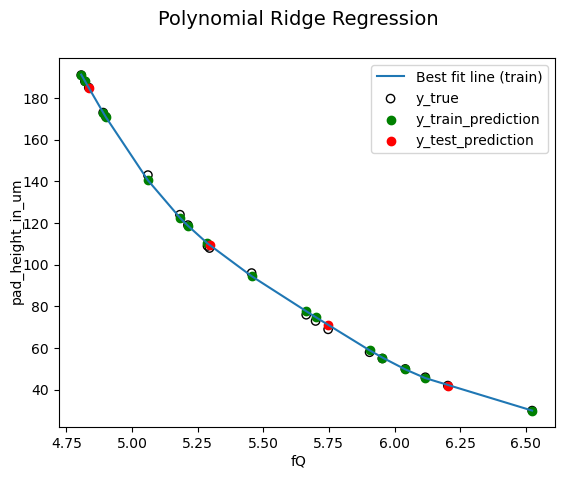

In [68]:
plot_result(data, X, y, test_size=TEST_SIZE, parameter=PARAMETER, metric=METRIC)

Save model

In [69]:
save_model(data["best_estimator"], MODEL_PATH)